# Value at Risk (VaR) Estimation
Goal: Implement Historical VaR, Parametric (Variance-Covariance) VaR, and Monte Carlo VaR for a portfolio.


In [18]:
!pip install yfinance --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

plt.style.use('default')


In [19]:
# Real data option:
# tickers = ['AAPL','MSFT','GOOG','AMZN']
# prices = yf.download(tickers, start='2020-01-01', end='2024-01-01')['Adj Close'].dropna()

# Synthetic fallback:
np.random.seed(0)
dates = pd.date_range('2020-01-01', periods=500)
tickers = ['AAPL','MSFT','GOOG','AMZN']
prices = pd.DataFrame(100 + np.cumsum(np.random.randn(500, len(tickers)), axis=0), index=dates, columns=tickers)

returns = prices.pct_change().dropna()
weights = np.array([0.25,0.25,0.25,0.25])  # equal weights
portfolio_returns = returns.dot(weights)
portfolio_returns.head()


,0
2020-01-02,0.004137
2020-01-03,0.004698
2020-01-04,0.004035
2020-01-05,0.001776
2020-01-06,-0.004095


In [20]:
def historical_var(returns, alpha=0.95):
    return -np.percentile(returns, (1-alpha)*100)

for alp in [0.95, 0.99]:
    print(f"Historical VaR at {int(alp*100)}%:", historical_var(portfolio_returns, alp))


Historical VaR at 95%: 0.008844260875922612
Historical VaR at 99%: 0.01168356482785997


In [21]:
def parametric_var(returns, alpha=0.95):
    mu = returns.mean()
    sigma = returns.std()
    from scipy.stats import norm
    z = norm.ppf(1-alpha)
    return -(mu + z * sigma)

for alp in [0.95, 0.99]:
    print(f"Parametric VaR at {int(alp*100)}%:", parametric_var(portfolio_returns, alp))


Parametric VaR at 95%: 0.008992595327521816
Parametric VaR at 99%: 0.012650164624854195


In [22]:
# Monte Carlo simulate portfolio returns using GBM approx on portfolio level
S0 = 1.0
mu = portfolio_returns.mean()
sigma = portfolio_returns.std()
T = 1/252  # 1-day horizon
n_sims = 20000

np.random.seed(42)
z = np.random.normal(0,1,n_sims)
sim_returns = (mu - 0.5*sigma**2)*T + sigma*np.sqrt(T)*z
sim_values = S0 * np.exp(sim_returns)
sim_pnl = sim_values - S0
# VaR at 95%
var_mc_95 = -np.percentile(sim_pnl, 5)
print("Monte Carlo VaR (1-day) 95%:", var_mc_95)


Monte Carlo VaR (1-day) 95%: 0.0005501200542951223


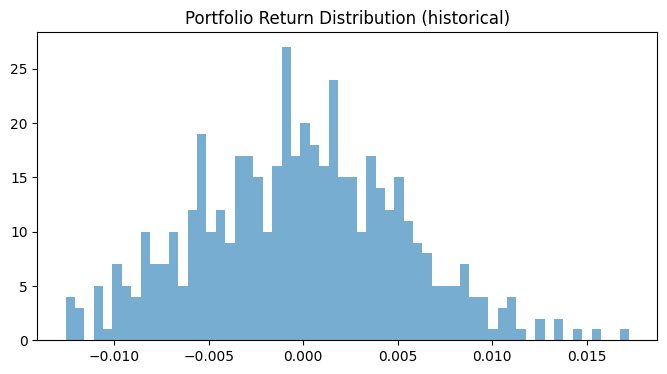

In [23]:
plt.figure(figsize=(8,4))
plt.hist(portfolio_returns, bins=60, alpha=0.6)
plt.title('Portfolio Return Distribution (historical)')
plt.show()


### Notes & Extensions
- Monte Carlo here is applied at portfolio-return level; for multi-asset MC simulate joint returns using Cholesky of covariance.
- Consider Expected Shortfall (CVaR) for tail risk.
